# Title: EEG based person authentication and identification

**Importing Neccessary Library**

In [1]:
import numpy as np
from glob import glob
from tqdm import tqdm
import pyedflib
import mne

 **Reading Data from an European Data File(EDF) consisting of Electroencephalogram (EEG) signals**

In [3]:
fname="C://Users//saich//Downloads//eeg-motor-movementimagery-dataset-1.0.0//files//S001//S001R14.edf"

In [4]:
raw = mne.io.read_raw_edf(fname,preload=True)

Extracting EDF parameters from C:\Users\saich\Downloads\eeg-motor-movementimagery-dataset-1.0.0\files\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [5]:
raw.filter(1,20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


<RawEDF | S001R14.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>

Using matplotlib as 2D backend.


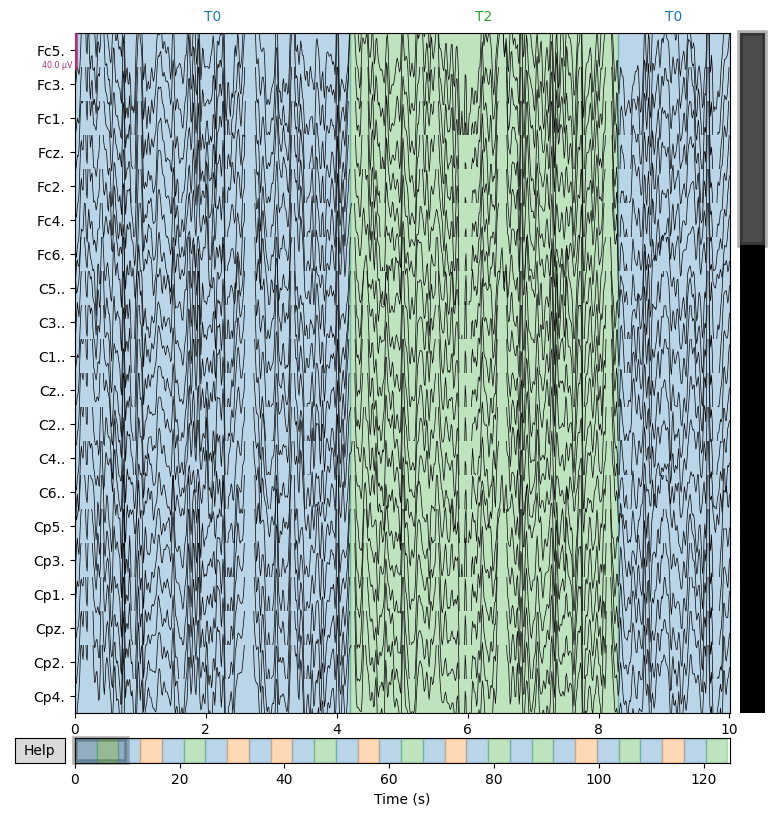

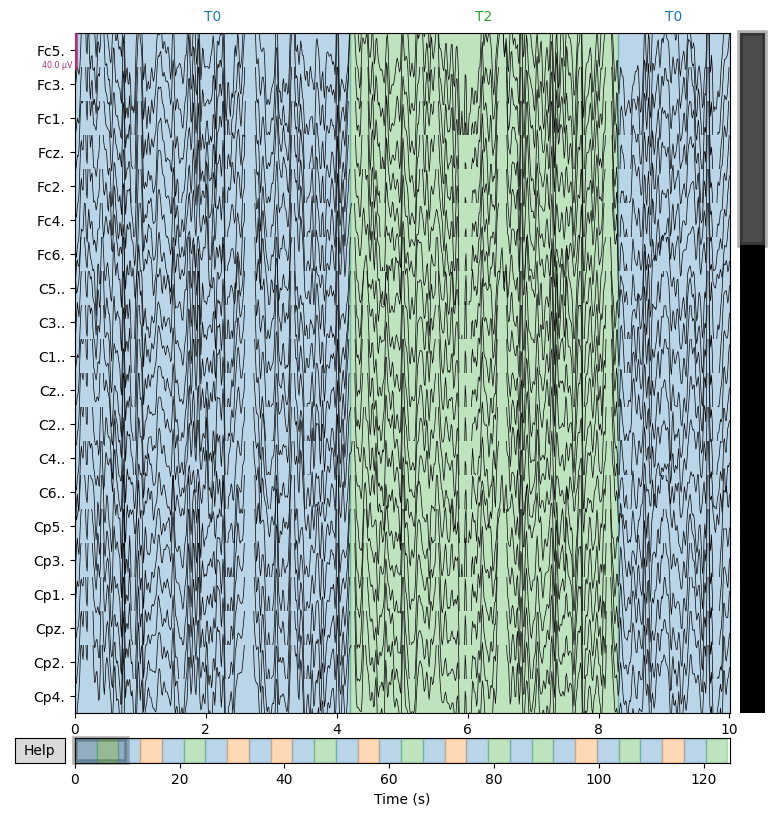

In [6]:
raw.plot()

**Features and target for model training** 

In [2]:
def _read_py_function(filename):
    file_content = pyedflib.EdfReader(filename)
    try:
        n_channels = file_content.signals_in_file
        channels = file_content.getSignalLabels() # Name of channels
        eeg_data = np.zeros((n_channels, file_content.getNSamples()[0]), dtype=np.float32)
        for i in np.arange(n_channels):
            eeg_data[i, :] = file_content.readSignal(i)

        n_samples = file_content.getNSamples()[0]
        reminder = int(n_samples % 160)
        n_samples -= reminder
        seconds = int(n_samples/160) #160 is frequency

        path = filename.split("//")
        person_id = int(path[-1].partition("S")[2].partition("R")[0]) #extract number between S and R
        label = np.zeros(4, dtype=bool) #No of classes (persons)
        label[person_id-1]=1
        labels = np.tile(label, (seconds,1))

        eeg_data = eeg_data.transpose()
        if reminder > 0:
            eeg_data = eeg_data[:-reminder, :]
        intervals = np.linspace(0, n_samples, num=seconds, endpoint=False, dtype=int)
        eeg_data = np.split(eeg_data, intervals) #return a list, remove the first empty
        del eeg_data[0]
        eeg_data = np.array(eeg_data)   #shape = (seconds, frequency, n_channels)

        return eeg_data, labels
    finally:
        file_content.close()

In [3]:
def get_dataset(input):
    dataset=[]
    i=1
    path = "C://Users//saich//Downloads//eeg-motor-movementimagery-dataset-1.0.0//files//"
    if input=='train':
        for i in range(1,5):
            dataset.append(glob(path + "S"+"{:03d}".format(i)+'//S'+"{:03d}".format(i)+'R01.edf'))
        for i in range(1,5):
            for j in range(2, 13):
                nth_record = glob(path + "S"+"{:03d}".format(i)+'//S'+"{:03d}".format(i)+'R' + "{:02d}".format(j) + ".edf")
                dataset.append((nth_record))
    elif input=="test":
        for i in range(1,5):
            dataset.append(glob(path + "S"+"{:03d}".format(i)+'//S'+"{:03d}".format(i)+'R13.edf'))
    elif input=="validation":
        for i in range(1,5):
            dataset.append(glob(path + "S"+"{:03d}".format(i)+'//S'+"{:03d}".format(i)+'R14.edf'))

    print(len(dataset))
    length = len(list(dataset))
    train_data = list()
    labels = list()

    with tqdm(total=length) as pbar:
        for filename in dataset:
            eeg_data, label = _read_py_function(filename[0])
            train_data.append(eeg_data)
            labels.append(label)
            pbar.update(1)
    print("Loaded")

    return train_data, labels


**Training Dataset**

In [4]:
training_dataset, training_labels = get_dataset(input='train')

48


  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:04<00:00, 10.34it/s]

Loaded


In [16]:
train_data = np.empty([1, 160, 64], dtype=np.float32)
train_data = np.vstack(training_dataset)
del(training_dataset)


train_label = np.empty([1, 1, 4], dtype=bool)
train_label = np.vstack(training_labels)
del(training_labels)

**Testing Data**

In [17]:
testing_dataset, testing_labels = get_dataset(input='test')

4


100%|██████████| 4/4 [00:00<00:00, 10.48it/s]

Loaded


In [18]:
test_data = np.empty([1, 160, 64], dtype=np.float32)
test_data = np.vstack(testing_dataset)
del(testing_dataset)

test_label = np.empty([1, 1, 4], dtype=bool)
test_label = np.vstack(testing_labels)
del(testing_labels)

In [19]:
train_data = np.reshape(train_data,(train_data.shape[0],train_data.shape[1]*train_data.shape[2]))
test_data = np.reshape(test_data,(test_data.shape[0],test_data.shape[1]*test_data.shape[2]))

In [20]:
train_label=np.array([j+1 for i in train_label for j,v in enumerate(i) if v])
test_label=np.array([j+1 for i in test_label for j,v in enumerate(i) if v])

In [21]:
print(train_data.shape,train_label.shape,test_data.shape,test_label.shape)

(5448, 10240) (5448,) (496, 10240) (496,)


**SVM Model**

In [22]:
from sklearn.svm import SVC

In [23]:
SVM_model = SVC()

In [24]:
SVM_model.fit(train_data, train_label)

SVC()

In [95]:
svm_prediction = SVM_model.predict(test_data)

In [26]:
from sklearn.metrics import confusion_matrix,classification_report

In [118]:
print(confusion_matrix(test_label,svm_prediction))

[[119   0   6   0]
 [ 23  85   9   6]
 [  1   0 124   0]
 [  4   5  13 101]]


In [119]:
SVM_Report = classification_report(test_label,svm_prediction,output_dict=True)
print(classification_report(test_label,svm_prediction))

              precision    recall  f1-score   support

           1       0.81      0.95      0.88       125
           2       0.94      0.69      0.80       123
           3       0.82      0.99      0.90       125
           4       0.94      0.82      0.88       123

    accuracy                           0.86       496
   macro avg       0.88      0.86      0.86       496
weighted avg       0.88      0.86      0.86       496



**KNN Model**

In [120]:
from sklearn.neighbors import KNeighborsClassifier

In [121]:
KNN_model=KNeighborsClassifier(n_neighbors=5)

In [122]:
KNN_model.fit(train_data, train_label)

KNeighborsClassifier()

In [123]:
knn_prediction = KNN_model.predict(test_data)

In [124]:
print(confusion_matrix(test_label,knn_prediction))

[[ 21  77   2  25]
 [  0 107   0  16]
 [  1   0 118   6]
 [  1  45   1  76]]


In [125]:
KNN_Report = classification_report(test_label,knn_prediction,output_dict=True)
print(classification_report(test_label,knn_prediction))

              precision    recall  f1-score   support

           1       0.91      0.17      0.28       125
           2       0.47      0.87      0.61       123
           3       0.98      0.94      0.96       125
           4       0.62      0.62      0.62       123

    accuracy                           0.65       496
   macro avg       0.74      0.65      0.62       496
weighted avg       0.74      0.65      0.62       496



**Decision Tree**

In [126]:
from sklearn.tree import DecisionTreeClassifier

In [127]:
DT_model = DecisionTreeClassifier()

In [128]:
DT_model.fit(train_data, train_label)

DecisionTreeClassifier()

In [129]:
dt_prediction = DT_model.predict(test_data)

In [130]:
print(confusion_matrix(test_label,dt_prediction))

[[ 65  15  34  11]
 [ 26  69  10  18]
 [  8   1 114   2]
 [  8   6   4 105]]


In [131]:
DT_Report = classification_report(test_label,dt_prediction,output_dict=True)
print(classification_report(test_label,dt_prediction))

              precision    recall  f1-score   support

           1       0.61      0.52      0.56       125
           2       0.76      0.56      0.64       123
           3       0.70      0.91      0.79       125
           4       0.77      0.85      0.81       123

    accuracy                           0.71       496
   macro avg       0.71      0.71      0.70       496
weighted avg       0.71      0.71      0.70       496



**Random Forest**

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [133]:
RF_model=RandomForestClassifier()

In [134]:
RF_model.fit(train_data,train_label)

RandomForestClassifier()

In [135]:
rf_prediction=RF_model.predict(test_data)

In [136]:
print(confusion_matrix(test_label,rf_prediction))

[[115   0  10   0]
 [ 38  76   8   1]
 [  1   0 124   0]
 [  4   1   8 110]]


In [137]:
RF_Report = classification_report(test_label,rf_prediction,output_dict=True)
print(classification_report(test_label,rf_prediction))

              precision    recall  f1-score   support

           1       0.73      0.92      0.81       125
           2       0.99      0.62      0.76       123
           3       0.83      0.99      0.90       125
           4       0.99      0.89      0.94       123

    accuracy                           0.86       496
   macro avg       0.88      0.86      0.85       496
weighted avg       0.88      0.86      0.85       496



**Ensemble Learning**

In [47]:
from sklearn.ensemble import VotingClassifier

In [48]:
model = VotingClassifier(estimators=[('svm',SVM_model),('knn',KNN_model),('dt',DT_model),('rf',RF_model)],voting='hard')
model.fit(train_data,train_label)
model.score(test_data,test_label)

0.8770161290322581

In [140]:
mo_prediction = model.predict(test_data)

In [141]:
print(confusion_matrix(test_label,mo_prediction))

[[120   0   4   1]
 [ 28  86   4   5]
 [  1   0 124   0]
 [  4   8   6 105]]


In [152]:
MO_Report = classification_report(test_label,mo_prediction,output_dict=True)
print(classification_report(test_label,mo_prediction))

              precision    recall  f1-score   support

           1       0.78      0.96      0.86       125
           2       0.91      0.70      0.79       123
           3       0.90      0.99      0.94       125
           4       0.95      0.85      0.90       123

    accuracy                           0.88       496
   macro avg       0.89      0.88      0.87       496
weighted avg       0.89      0.88      0.87       496



**Accuracy Analysis of all Models**

In [162]:
import pandas as pd

In [153]:
data=[]

svm_accuracy = SVM_Report['accuracy']
knn_accuracy = KNN_Report['accuracy']
dt_accuracy = DT_Report['accuracy']
rf_accuracy = RF_Report['accuracy']
mo_accuracy = MO_Report['accuracy']

data.append(['SVM', svm_accuracy*100])
data.append(['KNN', knn_accuracy*100])
data.append(['DT', dt_accuracy*100])
data.append(['RF', rf_accuracy*100])
data.append(['MO', mo_accuracy*100])

columns = ['Model', 'Accuracy']
accuracy_df = pd.DataFrame(data, columns=columns)

In [154]:
accuracy_df

,Model,Accuracy
0,SVM,86.491935
1,KNN,64.919355
2,DT,71.169355
3,RF,85.685484
4,MO,87.701613


In [163]:
import matplotlib.pyplot as plt
%matplotlib inline

(0.0, 1.0)

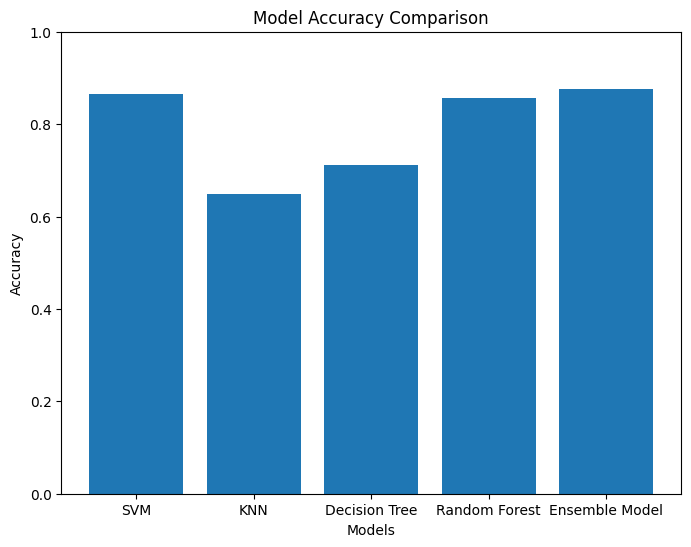

In [160]:
models = ['SVM', 'KNN', 'Decision Tree', 'Random Forest','Ensemble Model']
accuracy_scores = [svm_accuracy, knn_accuracy, dt_accuracy, rf_accuracy,mo_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracy_scores)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)

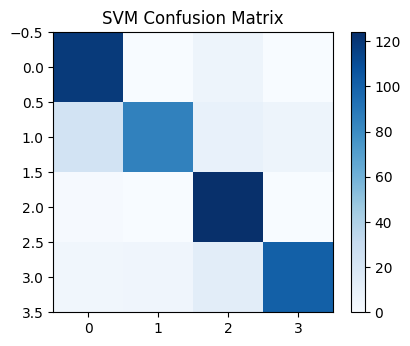

In [164]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(confusion_matrix(test_label, svm_prediction), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()

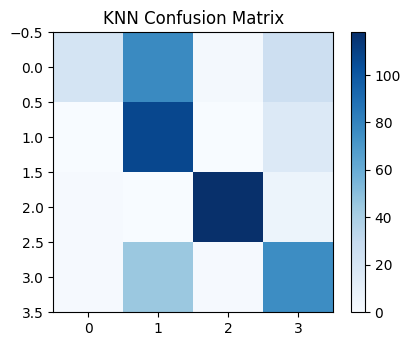

In [165]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 2)
plt.imshow(confusion_matrix(test_label, knn_prediction), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.colorbar()

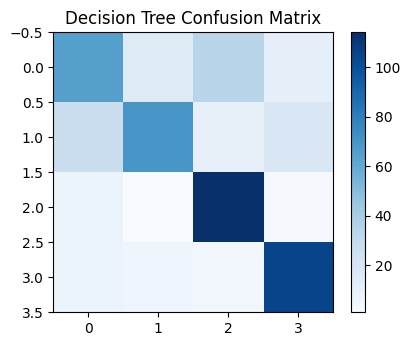

In [166]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 3)
plt.imshow(confusion_matrix(test_label, dt_prediction), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.colorbar()

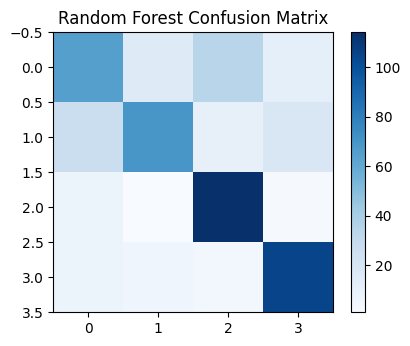

In [167]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 4)
plt.imshow(confusion_matrix(test_label, dt_prediction), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.colorbar()

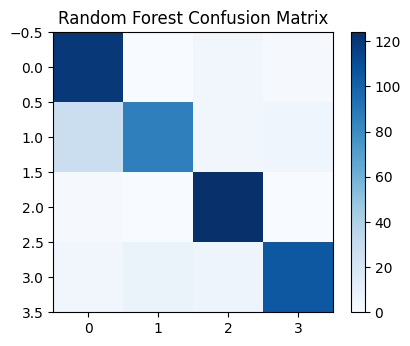

In [168]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 4)
plt.imshow(confusion_matrix(test_label, mo_prediction), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ensemble Learning Confusion Matrix')
plt.colorbar()